# Lstm english to hindi [seq to seq model]

* data_source:http://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/?C=D;O=A


In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
#pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
#https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
#https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    #sents = [i.split('\t') for i in sents]
    return sents

In [5]:
#data_source:http://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/?C=D;O=A
text_hin=read_text('parallel_hin_eng/parallel/IITB.en-hi.hi')
text_eng=read_text('parallel_hin_eng/parallel/IITB.en-hi.en')
data_hin=to_lines(text_hin)
data_eng=to_lines(text_eng)

In [6]:
#converting sentences to dataframe
df_hin=pd.DataFrame(data_hin)
df_eng=pd.DataFrame(data_eng)


In [7]:
df_eng.shape,df_hin.shape

((1561840, 1), (1561840, 1))

In [8]:
#removing punctutations from dataframe
#https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
df_eng[0]=df_eng[0].str.replace('[{}]'.format(string.punctuation), '')
df_hin[0]=df_hin[0].str.replace('[{}]'.format(string.punctuation), '')
df_eng.shape==df_hin.shape

True

In [9]:
#converting all dataframe to lowercase
df_eng[0]=df_eng[0].str.lower()
df_hin[0]=df_hin[0].str.lower()


In [10]:
#ref:https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe
eng_zero=[]
hin_zero=[]
c=0
for i in df_eng[0].str.strip().astype(bool):
    if(i==False):
        eng_zero.append(c)
    c+=1
    pass
c=0
for i in df_hin[0].str.strip().astype(bool):
    if(i==False):
        hin_zero.append(c)
    c+=1
    pass
remove_list=list(set(eng_zero+hin_zero))#remove_list has rows of empty values

#removing empty rows 
df_eng.drop(df_eng.index[remove_list], inplace=True)
df_eng.reset_index(inplace=True)
df_hin.drop(df_hin.index[remove_list], inplace=True)
df_hin.reset_index(inplace=True)

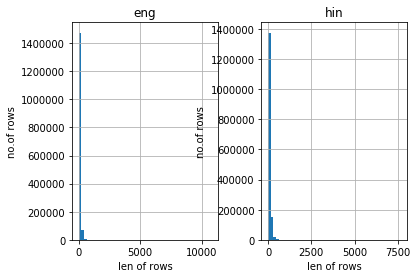

In [11]:
#EDA
df_len=pd.DataFrame()
df_len['eng']=df_eng[0].apply(len)
df_len['hin']=df_hin[0].apply(len)
fig=df_len.hist(bins =50)
 
for ax in fig.flatten():
    ax.set_xlabel("len of rows")
    ax.set_ylabel("no.of rows")

For english sentences *max_len= 10778 *min_len= 1 *avg_len= 70.60703200139896
For hindi sentences *max_len= 7645 *min_len= 1 *avg_len= 69.7714416316496


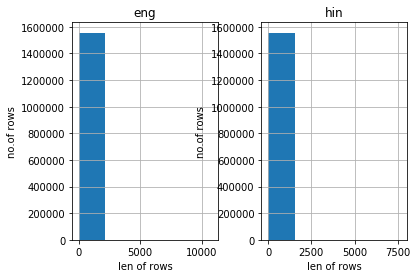

In [12]:
fig=df_len.hist(bins =5)
for ax in fig.flatten():
    ax.set_xlabel("len of rows")
    ax.set_ylabel("no.of rows")
    pass
print('For english sentences *max_len=',df_len['eng'].max(),'*min_len=',df_len['eng'].min(),'*avg_len=',df_len['eng'].mean())
print('For hindi sentences *max_len=',df_len['hin'].max(),'*min_len=',df_len['hin'].min(),'*avg_len=',df_len['hin'].mean())

In [13]:
df_eng.head()

,index,0
0,0,give your application an accessibility workout
1,1,accerciser accessibility explorer
2,2,the default plugin layout for the bottom panel
3,3,the default plugin layout for the top panel
4,4,a list of plugins that are disabled by default


In [14]:
df_hin.head()

,index,0
0,0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,1,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,2,निचले पटल के लिए डिफोल्ट प्लगइन खाका
3,3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
4,4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...


In [15]:
#ref:=http://carrefax.com/new-blog/2018/9/5/find-rows-containing-specific-values-in-a-pandas-dataframe
eng_zero=[]
hin_zero=[]
c=0
for i in df_eng[0].str.contains('([a-z])'):
    if(i==False):
        eng_zero.append(c)
    c+=1
    pass
c=0
for i in df_hin[0].str.contains('([a-z])'):
    if(i==True):
        hin_zero.append(c)
    c+=1
    pass
remove_list=list(set(eng_zero+hin_zero))#remove rows which contain eng words in hindhi sentences and vice versa

#removing rows 
df_eng.drop(df_eng.index[remove_list], inplace=True)
df_eng.reset_index(inplace=True)

df_hin.drop(df_hin.index[remove_list], inplace=True)
df_hin.reset_index(inplace=True)

print("percentage of data points removed =",(len(remove_list)/len(df_eng[0]))*100)

percentage of data points removed = 9.178406227407049


In [16]:
#ref:https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
#https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/
#https://medium.com/@ageitgey/machine-learning-is-fun-part-5-language-translation-with-deep-learning-and-the-magic-of-sequences-2ace0acca0aa
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [58]:
# prepare english tokenizer
eng_tokenizer = tokenization(df_eng[0][:50000])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('Size of English Vocabulary : %d' % eng_vocab_size)

Size of English Vocabulary : 3464


In [59]:
# prepare Deutch tokenizer
hin_tokenizer = tokenization(df_hin[0][:50000])
hin_vocab_size = len(hin_tokenizer.word_index) + 1

hin_length = 8
print('Size of Hindi Vocabulary : %d' % hin_vocab_size)

Size of Hindi Vocabulary : 4149


In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Model building

In [21]:
df=pd.DataFrame()
df['eng']=df_eng[0][:50000]
df['hin']=df_hin[0][:50000]

In [22]:
df.head(15)

,eng,hin
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...
5,highlight duration,अवधि को हाइलाइट रकें
6,the duration of the highlight box when selecti...,पहुंचनीय आसंधि नोड को चुनते समय हाइलाइट बक्से ...
7,highlight border color,सीमांत बोर्डर के रंग को हाइलाइट करें
8,the color and opacity of the highlight border,हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता।
9,highlight fill color,भराई के रंग को हाइलाइट करें


In [25]:
#SPLITTING DATA
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state = 42)
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train.iloc[:,0])
trainY = encode_sequences(hin_tokenizer, hin_length, train.iloc[:,1])
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test.iloc[:,0])
testY = encode_sequences(hin_tokenizer, hin_length, test.iloc[:,0])

In [27]:
#model
#ref:https://keras.io/layers/core/
#ref:https://datascience.stackexchange.com/questions/46491/what-is-the-job-of-repeatvector-and-timedistributed
model = Sequential()
model.add(Embedding(eng_vocab_size, 512, input_length=eng_length, mask_zero=True))
model.add(LSTM(512))
model.add(RepeatVector(hin_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(hin_vocab_size, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
#https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
#https://medium.com/@ageitgey/machine-learning-is-fun-part-5-language-translation-with-deep-learning-and-the-magic-of-sequences-2ace0acca0aa#saving model
filename = 'model_eng2hin.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=256, 
          validation_split = 0.25,
          callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 28125 samples, validate on 9375 samples
Epoch 1/50
28125/28125 [==============================] - 176s 6ms/step - loss: 3.3790 - val_loss: 2.9463

Epoch 00001: val_loss improved from inf to 2.94635, saving model to model_eng2hin.h1.24_jan_19
Epoch 2/50
28125/28125 [==============================] - 176s 6ms/step - loss: 2.8377 - val_loss: 2.7242

Epoch 00002: val_loss improved from 2.94635 to 2.72421, saving model to model_eng2hin.h1.24_jan_19
Epoch 3/50
28125/28125 [==============================] - 173s 6ms/step - loss: 2.6454 - val_loss: 2.5334

Epoch 00003: val_loss improved from 2.72421 to 2.53343, saving model to model_eng2hin.h1.24_jan_19
Epoch 4/50
28125/28125 [==============================] - 172s 6ms/step - loss: 2.4410 - val_loss: 2.4443

Epoch 00004: val_loss improved from 2.53343 to 2.44430, saving model to model_eng2hin.h1.24_jan_19
Epoch

28125/28125 [==============================] - 170s 6ms/step - loss: 0.0883 - val_loss: 0.3449

Epoch 00039: val_loss did not improve from 0.34282
Epoch 40/50
28125/28125 [==============================] - 167s 6ms/step - loss: 0.0873 - val_loss: 0.3456

Epoch 00040: val_loss did not improve from 0.34282
Epoch 41/50
28125/28125 [==============================] - 168s 6ms/step - loss: 0.0862 - val_loss: 0.3469

Epoch 00041: val_loss did not improve from 0.34282
Epoch 42/50
28125/28125 [==============================] - 167s 6ms/step - loss: 0.0855 - val_loss: 0.3451

Epoch 00042: val_loss did not improve from 0.34282
Epoch 43/50
28125/28125 [==============================] - 167s 6ms/step - loss: 0.0842 - val_loss: 0.3472

Epoch 00043: val_loss did not improve from 0.34282
Epoch 44/50
28125/28125 [==============================] - 167s 6ms/step - loss: 0.0842 - val_loss: 0.3473

Epoch 00044: val_loss did not improve from 0.34282
Epoch 45/50
28125/28125 [==============================] -

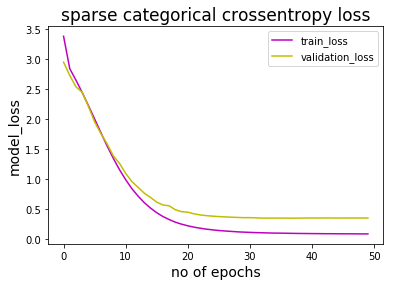

In [81]:
plt.plot(history.history['loss'],c='m')
plt.plot(history.history['val_loss'],c='y')
plt.legend(['train_loss','validation_loss'])
#ref:https://in.mathworks.com/help/matlab/ref/title.html
plt.title('sparse categorical crossentropy loss',fontsize = 17)
plt.xlabel('no of epochs',fontsize = 14)
plt.ylabel('model_loss',fontsize = 14)
plt.show()

In [47]:
model = load_model('model_eng2hin.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [48]:
#ref:https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [49]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], hin_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], hin_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [57]:
pred_df = pd.DataFrame({'actual_words' : test.iloc[:,1], 'predicted_words' : preds_text})
pred_df.sample(50)#random words

,actual_words,predicted_words
28344,कलाकारः,कलाकारः
46697,वेबसाइटों खुद के सीएसएस को संशोधित करने के लिए...,कस्टम सीएसएस फ़ाइल का उपयोग करने के लिए
36407,काल इतिहास देखें,काल इतिहास देखें
37173,कृपया अपना कनेक्शन प्रकार चुनेंः,कृपया अपना कनेक्शन प्रकार चुनेंः
29279,सामान्य,सामान्य
32492,कम्पाइल किया गया,कम्पाइल किया गया
34736,सही,किसी के लिए जांच
47371,दिया सत्र फ़ाइल लोड करें,दिया सत्र फ़ाइल लोड करें
27318,क्या फ़ाइल पूर्वालोकन को दिखाना है इसे प्रयोग ...,इसे प्रयोग के लिए सही पर सेट करें
17115,असफल को मिटाएँ से नहीं से,असफल को मिटाएँ से नहीं से
